# Estimating Pass Difficulty

##### *Devin Pleuler, March 2019*

### Using **Statsbomb** [Open Data][1] from *World Cup 2018*

#### Tutorial will cover:
- Downloading and Parsing Statsbomb JSON
- Building Basic Logistic Regression Model
- Evaluating Model using ROC Curve
- Feature Engineering
- Building Piecewise Model

#### Dependencies Include:
- pandas
- numpy
- scikit-learn
- matplotlib

[1]: https://github.com/statsbomb/open-data "Statsbomb Open Data Github Repository"

In [1]:
# Nice trick for high-resolution figures on retina screen
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducability
np.random.seed(42)

### Downloading and Parsing Statsbomb Data

In [4]:
import requests

In [5]:
# Statsbomb's competition 43 is the World Cup
match_info_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/43.json"

# Pull data from url into python dictionary
games = requests.get(url=match_info_url).json()

# Use list comprehension to create a list of match ids
match_ids = [g['match_id'] for g in games]

print("There are {} games in this list".format(len(match_ids)))

There are 64 games in this list


In [6]:
data = []

# template URL at which each game's event data is stored
match_data_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json"

# This takes some time, naturally
for match_id in match_ids:
    
    # Get all events from a particular game
    all_events = requests.get(url=match_data_url.format(match_id)).json()
        
    # Filter them by type-name Pass
    passes = [x for x in all_events if x['type']['name'] == "Pass"]
    
    for p in passes:
        attributes = {
            "x": p['location'][0],
            "y": p['location'][1],
            "end_x": p['pass']['end_location'][0],
            "end_y": p['pass']['end_location'][1],
            "length": p['pass']['length'],
            "angle": p['pass']['angle'],
            # Multiple other features can be collected here, such as pressure
            "outcome": 0 if "outcome" in p['pass'] else 1
        }
        
        data.append(attributes)

In [7]:
# How many passes are we dealing with?
print(len(data))

62871


In [8]:
# Build Pandas Dataframe
df = pd.DataFrame(data=data, columns=["outcome", "x", "y", "end_x", "end_y", "length", "angle"])
df.head()

,outcome,x,y,end_x,end_y,length,angle
0,1,60.0,40.0,44.0,47.0,17.464249,2.729182
1,1,44.0,45.0,38.0,73.0,28.635643,1.781890
2,1,38.0,72.0,24.0,59.0,19.104973,-2.393215
3,1,24.0,59.0,21.0,31.0,28.160255,-1.677532
4,1,21.0,28.0,31.0,4.0,26.000000,-1.176005


### Plot some Passes!

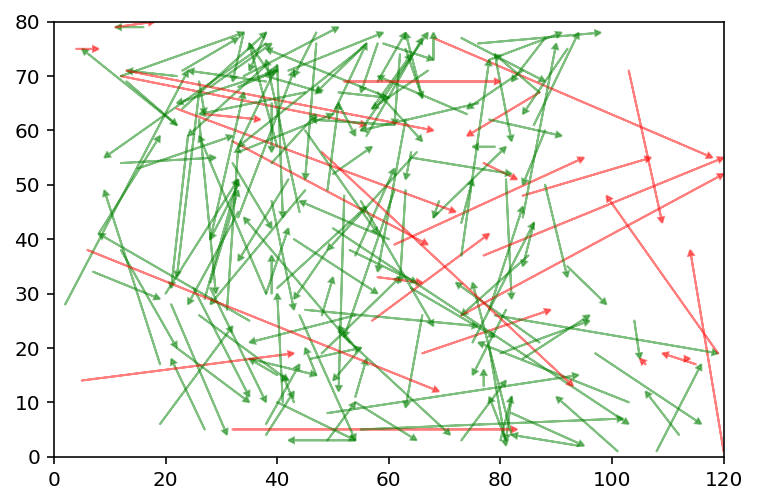

In [9]:
for x,y,end_x,end_y,outcome in df[["x", "y", "end_x", "end_y", "outcome"]].head(200).values:
    
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='green' if outcome == 1 else 'red',
              alpha=0.5,
              length_includes_head=True)
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

### Baseline Accuracy

In [10]:
# What percentage of overall passes are completed?

baseline_accuracy = df['outcome'].mean()
print("{:.1f}%".format(baseline_accuracy*100))

79.8%


### Basic Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
basic_model = LogisticRegression()

features = df[['angle', 'length']]
labels = df['outcome']

basic_model.fit(features, labels)

# Make Predictions
predictions = basic_model.predict_proba(features)[:, 1]

In [13]:
print(predictions[:5])

[0.82949653 0.76822101 0.81869044 0.76885244 0.78197559]


In [14]:
# What percentage of these predictions are "correct"?
correct = 0

for i, prob in enumerate(predictions):
    pred = 1 if prob > 0.5 else 0
    
    if pred == labels[i]:
        correct += 1
        
print("{} of {} correct ({:.2f}%)".format(correct, len(labels), correct/len(labels)))

50687 of 62871 correct (0.81%)


### Sensitivity and Specificity (Slides)

### Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix

threshold = 0.5
confusion_matrix(labels, [1 if prob > threshold else 0 for prob in predictions])

# How to Read Confusion Matrix:

# True Negatives, False Positives
# False Negatives, True Positives

array([[ 1090, 11622],
       [  562, 49597]])

### Evaluating Predictions using ROC

ROC = Receiver Operating Characteristic

AUC = Area Under Curve

In [16]:
from sklearn import metrics

In [17]:
def draw_roc(labels, predictions):
    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions, pos_label=1)
    auc = metrics.roc_auc_score(labels, predictions)
    plt.plot(fpr,tpr,label="AUC: {:.3f}".format(auc))
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()

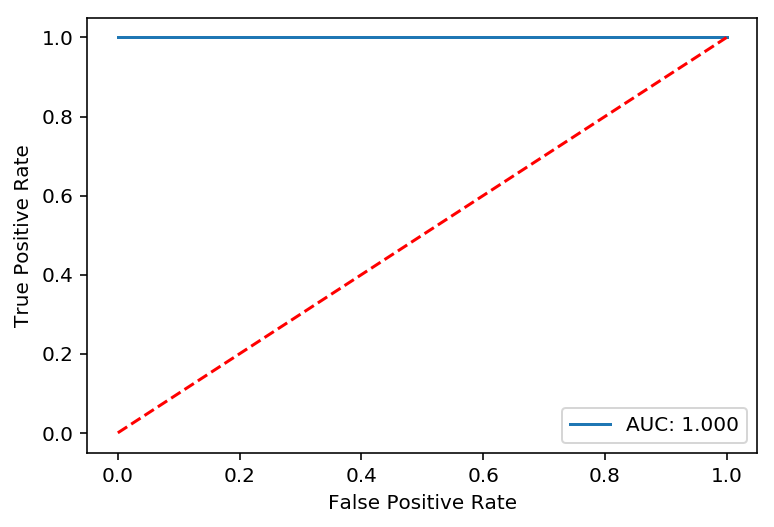

In [18]:
# Perfect ROC
draw_roc(labels, labels)

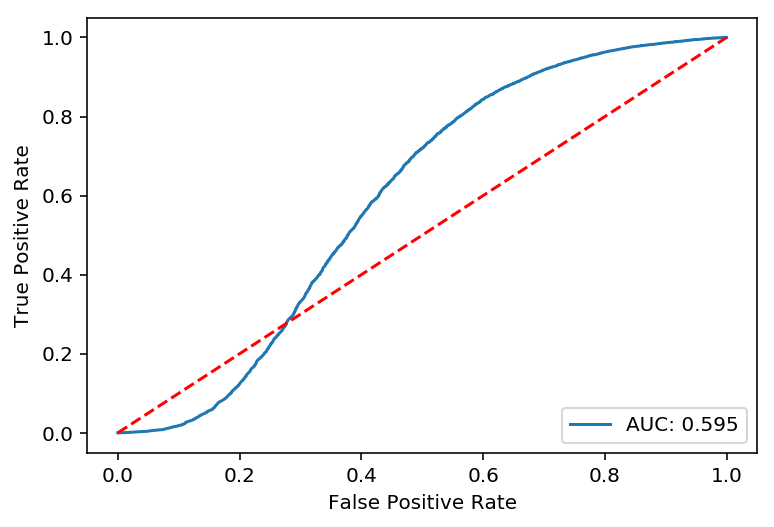

In [19]:
# ROC for regression predictions
draw_roc(labels, predictions)

### Feature Engineering

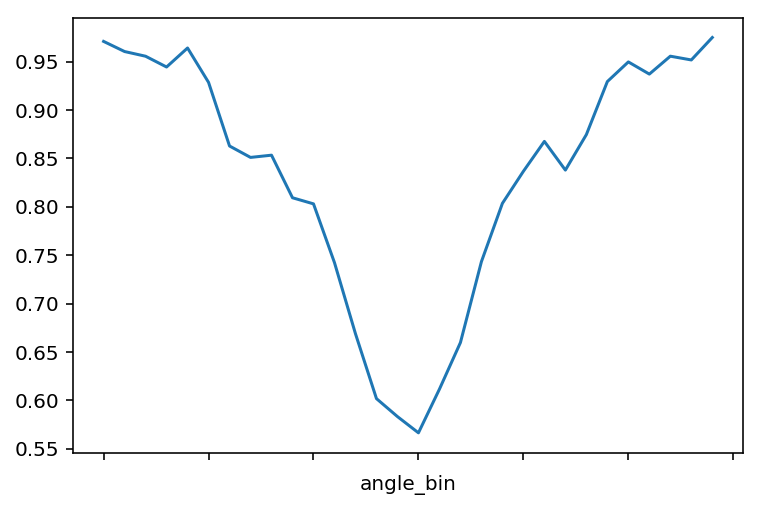

In [20]:
# Angle is provided in radians and ranges from -pi to +pi
# An angle of 0 is directly up the field

bins = np.linspace(-3.14,3.14,31)
df['angle_bin'] = pd.cut(df['angle'], bins=bins)

ax = df[['angle_bin', 'outcome']].groupby('angle_bin').mean()['outcome'].plot()

In [21]:
# Create new column in data frame
df['abs_angle'] = abs(df['angle'])
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle
0,1,60.0,40.0,44.0,47.0,17.464249,2.729182,"(2.721, 2.931]",2.729182
1,1,44.0,45.0,38.0,73.0,28.635643,1.781890,"(1.675, 1.884]",1.781890
2,1,38.0,72.0,24.0,59.0,19.104973,-2.393215,"(-2.512, -2.303]",2.393215
3,1,24.0,59.0,21.0,31.0,28.160255,-1.677532,"(-1.884, -1.675]",1.677532
4,1,21.0,28.0,31.0,4.0,26.000000,-1.176005,"(-1.256, -1.047]",1.176005


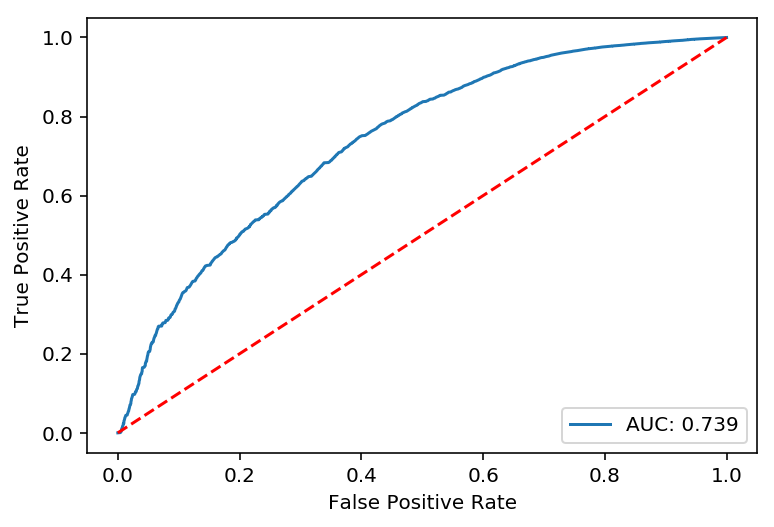

In [22]:
# Build another logistic regression model using new features
adjusted_model = LogisticRegression()

features = df[['abs_angle', 'length']]
labels = df['outcome']
basic_model.fit(features,labels)

predictions = basic_model.predict_proba(features)[:, 1]

draw_roc(labels, predictions)

### Build Piecewise Model

In [23]:
from sklearn.cluster import KMeans

In [24]:
# Cluster all passes into 50 different types
cluster_model = KMeans(n_clusters=50).fit(df[['x','y','end_x','end_y']])

# store cluster classification as an additional column in data frame
df['cluster'] = cluster_model.predict(df[['x','y','end_x','end_y']])

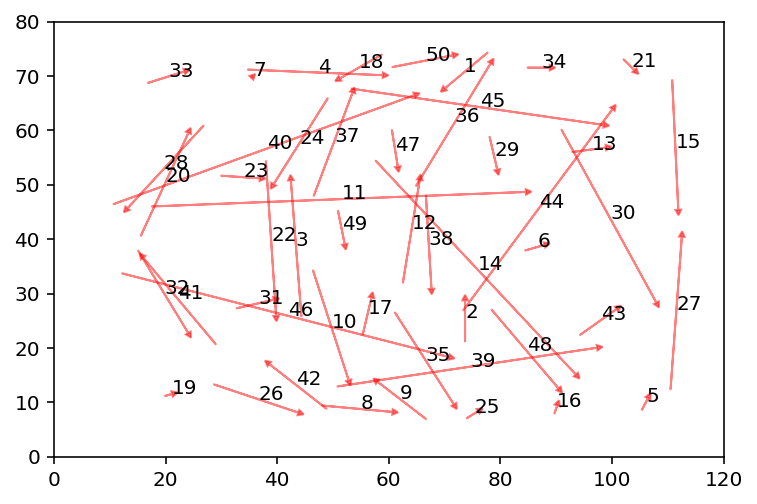

In [25]:
# Plot all clusters
for i, (x, y, end_x, end_y) in enumerate(cluster_model.cluster_centers_):
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='red',
              alpha=0.5,
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

In [26]:
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle,cluster
0,1,60.0,40.0,44.0,47.0,17.464249,2.729182,"(2.721, 2.931]",2.729182,48
1,1,44.0,45.0,38.0,73.0,28.635643,1.781890,"(1.675, 1.884]",1.781890,36
2,1,38.0,72.0,24.0,59.0,19.104973,-2.393215,"(-2.512, -2.303]",2.393215,6
3,1,24.0,59.0,21.0,31.0,28.160255,-1.677532,"(-1.884, -1.675]",1.677532,27
4,1,21.0,28.0,31.0,4.0,26.000000,-1.176005,"(-1.256, -1.047]",1.176005,18


In [27]:
# Build an individualized logistic regression model for each pass type
models = {}

for i, e in enumerate(cluster_model.cluster_centers_):
    passes_in_cluster = df[df['cluster'] == i]
    
    models[i] = LogisticRegression()
    
    features = passes_in_cluster[['abs_angle', 'length']]
    labels = passes_in_cluster['outcome']
    
    models[i].fit(features,labels)

In [28]:
def get_prediction(cluster, abs_angle, length):
    v = np.array([abs_angle, length]).reshape(1,-1)    
    return models[cluster].predict_proba(v)[:, 1]

In [29]:
# vectorize get prediction funtion for fast results
get_prediction = np.vectorize(get_prediction)

# create additional column in data frame to store predictions
df['predictions'] = get_prediction(df['cluster'], df['abs_angle'], df['length'])

In [30]:
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle,cluster,predictions
0,1,60.0,40.0,44.0,47.0,17.464249,2.729182,"(2.721, 2.931]",2.729182,48,0.988922
1,1,44.0,45.0,38.0,73.0,28.635643,1.781890,"(1.675, 1.884]",1.781890,36,0.980665
2,1,38.0,72.0,24.0,59.0,19.104973,-2.393215,"(-2.512, -2.303]",2.393215,6,0.970603
3,1,24.0,59.0,21.0,31.0,28.160255,-1.677532,"(-1.884, -1.675]",1.677532,27,0.994706
4,1,21.0,28.0,31.0,4.0,26.000000,-1.176005,"(-1.256, -1.047]",1.176005,18,0.785621


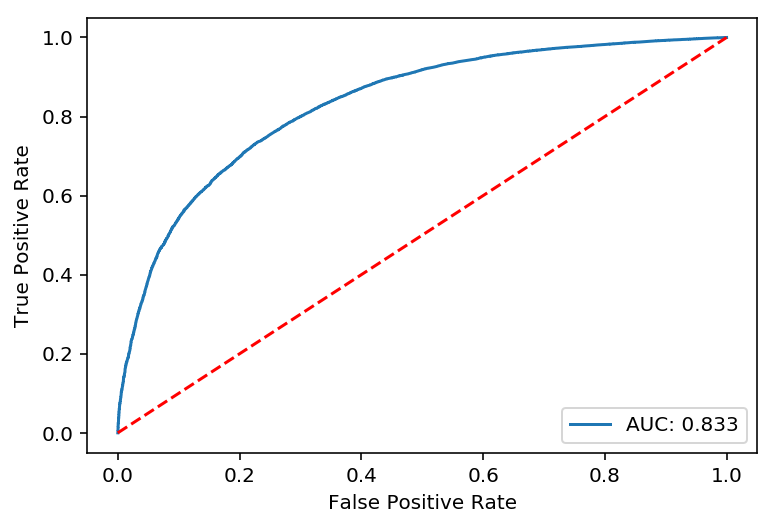

In [31]:
# Draw ROC of final piecewise model
draw_roc(df['outcome'], df['predictions'])